In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pygad

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

tf.random.set_seed(0)
np.random.seed(0)

2023-06-14 13:13:07.514948: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-14 13:13:10.133521: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/macula/SMATousi/.conda/envs/mac-deep/lib/:/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/nvidia/cudnn/lib
2023-06-14 13:13:10.133824: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8812626748485784889
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10088022016
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3305891855274607522
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:19:00.0, compute capability: 7.5"
xla_global_id: 416903419
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 10088022016
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5673748931610140947
physical_device_desc: "device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5"
xla_global_id: 2144165316
, name: "/device:GPU:2"
device_type: "GPU"
memory_limit: 10088022016
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11181711828568555171
physical_device_desc: "device: 2, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:67:00.0, compute capability: 7.5"
xla_global_id: 1651660799
, name: "/de

2023-06-14 13:13:15.235535: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-14 13:13:17.277411: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /device:GPU:0 with 9620 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:19:00.0, compute capability: 7.5
2023-06-14 13:13:17.278160: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /device:GPU:1 with 9620 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5
2023-06-14 13:13:17.278762: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /device:GPU:2 with 9620 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 2080 Ti

# Creating the dataset

In [10]:
num_samples = 10000
num_dimensions = 30

# Generate random samples
raw_data = np.random.rand(num_samples, num_dimensions)

outlier_indices_1 = [0,1,2,3,4,5,6]
outlyin_amount_1 = 20
outlier_indices_2 = [0,2,4,6,8,10,12]
outlyin_amount_2 = 10
outlier_indices_3 = [0,3,6,9,12,15,18]
outlyin_amount_3 = 5
outlier_indices_4 = [0,4,8,12,16,20,24]
outlyin_amount_4 = 2
outlier_indices_5 = [0,5,10,15,20,25,29]
outlyin_amount_5 = 1.1
outlier_indices_6 = [0,1,2,3,4,5,6]
outlyin_amount_6 = [20,15,10,5,2,1.1,1.05]

corrupted_data = raw_data

corrupted_data[100:120, outlier_indices_1] = outlyin_amount_1
corrupted_data[200:220, outlier_indices_2] = outlyin_amount_2
corrupted_data[300:320, outlier_indices_3] = outlyin_amount_3
corrupted_data[400:420, outlier_indices_4] = outlyin_amount_4
corrupted_data[500:520, outlier_indices_5] = outlyin_amount_5
corrupted_data[600:620, outlier_indices_6] = outlyin_amount_6

for outlier_gene_index in range(corrupted_data.shape[1]+1):
    corrupted_data[700+outlier_gene_index,:outlier_gene_index] = outlyin_amount_1
    

# print(raw_data)

In [16]:
corrupted_data[701]

array([20.        ,  0.75762593,  0.86866608,  0.7162405 ,  0.36125389,
        0.29366277,  0.90369206,  0.14690194,  0.04087951,  0.61418229,
        0.19055894,  0.25650025,  0.46644617,  0.56207388,  0.66471959,
        0.4999194 ,  0.36030109,  0.34818894,  0.99563774,  0.91184597,
        0.57961046,  0.04904301,  0.77580245,  0.93319094,  0.19946647,
        0.56109009,  0.4533536 ,  0.5588837 ,  0.06989497,  0.3189912 ])

# Training the VAE

In [13]:

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


latent_dim = 2

encoder_inputs = keras.Input(shape=(30,))
# x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
# x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
# x = layers.Flatten()(x)
x = layers.Dense(30, activation="tanh")(encoder_inputs)
x = layers.Dense(20, activation="tanh")(x)
x = layers.Dense(18, activation="tanh")(x)
x = layers.Dense(16, activation="tanh")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

latent_inputs = keras.Input(shape=(latent_dim,))
# x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
# x = layers.Reshape((7, 7, 64))(x)
# x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
# x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
# decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
x = layers.Dense(16, activation="tanh")(latent_inputs)
x = layers.Dense(18, activation="tanh")(x)
x = layers.Dense(20, activation="tanh")(x)
decoder_outputs = layers.Dense(30, activation="tanh")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")



class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
#             reconstruction_loss = tf.reduce_mean(
#                 tf.reduce_sum(
#                     keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
#                 )
#             )
            reconstruction_loss = tf.keras.losses.MeanSquaredError()(data,reconstruction)
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

creditdata = np.concatenate([corrupted_data], axis=0)
creditdata = np.expand_dims(creditdata, -1).astype("float32")

vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.legacy.Adam())
vae.fit(creditdata, epochs=100, batch_size=128)

2023-06-14 13:17:11.382831: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9620 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:19:00.0, compute capability: 7.5
2023-06-14 13:17:11.383176: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9620 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5
2023-06-14 13:17:11.383496: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 9620 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:67:00.0, compute capability: 7.5
2023-06-14 13:17:11.383820: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 9493 MB memory:  -> device: 3, name: NVIDIA GeForce RTX

Epoch 1/100
79/79 [==============================] - 2s 6ms/step - loss: 1.1752 - reconstruction_loss: 1.1217 - kl_loss: 0.0325
Epoch 2/100
79/79 [==============================] - 1s 6ms/step - loss: 0.8591 - reconstruction_loss: 0.9452 - kl_loss: 0.0028
Epoch 3/100
79/79 [==============================] - 1s 6ms/step - loss: 0.9545 - reconstruction_loss: 0.9377 - kl_loss: 0.0012
Epoch 4/100
79/79 [==============================] - 1s 7ms/step - loss: 1.0954 - reconstruction_loss: 0.9973 - kl_loss: 7.4190e-04
Epoch 5/100
79/79 [==============================] - 1s 6ms/step - loss: 0.8648 - reconstruction_loss: 0.9374 - kl_loss: 5.2752e-04
Epoch 6/100
79/79 [==============================] - 1s 7ms/step - loss: 0.8517 - reconstruction_loss: 0.9365 - kl_loss: 4.1363e-04
Epoch 7/100
79/79 [==============================] - 1s 6ms/step - loss: 0.8871 - reconstruction_loss: 0.9360 - kl_loss: 3.1155e-04
Epoch 8/100
79/79 [==============================] - 1s 7ms/step - loss: 0.9720 - recons

79/79 [==============================] - 1s 6ms/step - loss: 0.8966 - reconstruction_loss: 0.9358 - kl_loss: 5.5177e-05
Epoch 63/100
79/79 [==============================] - 0s 6ms/step - loss: 0.9526 - reconstruction_loss: 0.9357 - kl_loss: 7.3474e-05
Epoch 64/100
79/79 [==============================] - 1s 6ms/step - loss: 1.0202 - reconstruction_loss: 0.9358 - kl_loss: 1.1457e-04
Epoch 65/100
79/79 [==============================] - 1s 6ms/step - loss: 1.0156 - reconstruction_loss: 0.9964 - kl_loss: 6.2351e-05
Epoch 66/100
79/79 [==============================] - 1s 6ms/step - loss: 1.0059 - reconstruction_loss: 0.9362 - kl_loss: 6.9384e-05
Epoch 67/100
79/79 [==============================] - 1s 6ms/step - loss: 1.0570 - reconstruction_loss: 0.9357 - kl_loss: 9.6387e-05
Epoch 68/100
79/79 [==============================] - 1s 6ms/step - loss: 0.9332 - reconstruction_loss: 0.9515 - kl_loss: 7.5691e-05
Epoch 69/100
79/79 [==============================] - 1s 6ms/step - loss: 0.9014 -

The error calculation for setting the threshold

In [28]:
inliers = corrupted_data[5:80,:]
mean_data = np.mean(corrupted_data, axis=0)
outlier1 = corrupted_data[101,:]



# #------------------ replacing the genes here ---------------------

# inliers[:,1] = mean_data[1]

# outlier1[1] = mean_data[1]

# # ----------------------------------------------------------------

mean_mean = []

for step in range(10):

    mean_data = mean_data.reshape([1,30])

    z_mean, z_log_var, z = vae.encoder(mean_data)
    reconstruction = vae.decoder(z)

    reconstruction_loss = tf.keras.losses.MeanSquaredError()(mean_data,reconstruction)

    print(reconstruction_loss.numpy())
    
    mean_mean.append(reconstruction_loss.numpy())

print("MEAN_MEAN = ", np.mean(np.array(mean_mean)))
print("std_MEAN = ", np.std(np.array(mean_mean)))

0.00023751048
0.00031813743
0.00062482443
0.0003826774
0.0004886425
0.00065471797
0.00012117691
0.00057482027
0.00026806025
0.0006355101
MEAN_MEAN =  0.0004306078
std_MEAN =  0.00018124522


In [26]:
mean_mean = []

for step in range(10):

    mean_ins_error = []

    for index in range(inliers.shape[0]):

        cand = inliers[index,:]

        cand = cand.reshape([1,30])

        mean_data = mean_data.reshape([1,30])

        z_mean, z_log_var, z = vae.encoder(cand)
        reconstruction = vae.decoder(z)

        reconstruction_loss = tf.keras.losses.MeanSquaredError()(cand,reconstruction)

        mean_ins_error.append(reconstruction_loss.numpy())

    #     print("MEAN", index, " = ", reconstruction_loss.numpy())

    mean_ins_error = np.array(mean_ins_error)
    print("mean = ", np.mean(mean_ins_error))
    
    mean_mean.append(np.mean(mean_ins_error))
    

print("MEAN_MEAN = ", np.mean(np.array(mean_mean)))
print("std_MEAN = ", np.std(np.array(mean_mean)))

mean =  0.09346731
mean =  0.093473025
mean =  0.09328781
mean =  0.09301095
mean =  0.093280695
mean =  0.09336068
mean =  0.09343386
mean =  0.09351533
mean =  0.093119495
mean =  0.09344801
MEAN_MEAN =  0.09333972
std_MEAN =  0.00015769768


Setting the threshold and trying to detect the outliers:

In [7]:
for item_no in range(corrupted_data.shape[0]):
    
    candidate_sample = corrupted_data[item_no,:]
    candidate_sample = candidate_sample.reshape([1,30])
    
    z_mean, z_log_var, z = vae.encoder(candidate_sample)
    reconstruction = vae.decoder(z)

    reconstruction_loss = tf.keras.losses.MeanSquaredError()(candidate_sample,reconstruction)
    
    if reconstruction_loss.numpy() > 1:
        
        print("An Outlier Detected on sample No. ", item_no)

An Outlier Detected on sample No.  100
An Outlier Detected on sample No.  101
An Outlier Detected on sample No.  102
An Outlier Detected on sample No.  103
An Outlier Detected on sample No.  104
An Outlier Detected on sample No.  105
An Outlier Detected on sample No.  106
An Outlier Detected on sample No.  107
An Outlier Detected on sample No.  108
An Outlier Detected on sample No.  109
An Outlier Detected on sample No.  110
An Outlier Detected on sample No.  111
An Outlier Detected on sample No.  112
An Outlier Detected on sample No.  113
An Outlier Detected on sample No.  114
An Outlier Detected on sample No.  115
An Outlier Detected on sample No.  116
An Outlier Detected on sample No.  117
An Outlier Detected on sample No.  118
An Outlier Detected on sample No.  119
An Outlier Detected on sample No.  200
An Outlier Detected on sample No.  201
An Outlier Detected on sample No.  202
An Outlier Detected on sample No.  203
An Outlier Detected on sample No.  204
An Outlier Detected on sa

KeyboardInterrupt: 

# Genetic Part

In [19]:
def fitness_func_avg(ga_instance, solution, solution_idx):
    
    inliers = corrupted_data[10:13,:]
    
    avg_ins = np.mean(inliers, axis=0)
    avg_ins = avg_ins.reshape([1,30])
    
    particle = corrupted_data[701,:]
    particle = particle.reshape([1,30])
    
#     abn_subspace = solution * val_features[6728,:]
    
#     abn_subspace = abn_subspace.reshape([1,30])

    avg_in_rec = []
    
    for index in range(inliers.shape[0]):
        
        candidate_inlier = inliers[index,:]
        candidate_inlier = candidate_inlier.reshape([1,30])
        
        in_remain = candidate_inlier * solution
        
        in_normal_subspace = 1 - solution
        
        in_replace = in_normal_subspace * avg_ins
        
        in_candidate = in_remain + in_replace
        
        z_mean, z_log_var, z = vae.encoder(in_candidate)
        in_candidate_rec = vae.decoder(z)
        
        
        rec_loss = tf.keras.losses.MeanSquaredError()(in_candidate,in_candidate_rec)
        
        avg_in_rec.append(rec_loss.numpy())
    
    avg_in_rec = np.array(avg_in_rec)
    avg_in_rec = np.mean(avg_in_rec)
        
        
    
    

#     z_mean, z_log_var, z = vae.encoder(particle)
#     reconstruction_1 = vae.decoder(z)
    
    out_remain = particle * solution
    
    out_normal_subspace = 1 - solution
    
    out_replace = avg_ins * out_normal_subspace
    
    out_candidate = out_remain + out_replace
    
    
    z_mean, z_log_var, z = vae.encoder(out_candidate)
    out_candidate_rec = vae.decoder(z)
    
    rec_loss = tf.keras.losses.MeanSquaredError()(out_candidate,out_candidate_rec)
    rec_loss = rec_loss.numpy()
    
    fitness = rec_loss / avg_in_rec
    
    return fitness

def on_generation(ga):
    print("Generation", ga.generations_completed)
    
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    
    print(solution_fitness)


fitness_function = fitness_func_avg

num_generations = 20
num_parents_mating = 4

sol_per_pop = 100
num_genes = corrupted_data.shape[1]

init_range_low = -2
init_range_high = 5

parent_selection_type = "sss"
keep_parents = 1

space = [[0,1] for i in range(num_genes)]

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 10

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       on_generation=on_generation,
                       gene_space = space)

In [20]:
ga_instance.run()

Generation 1
243.33113
Generation 2
266.78687
Generation 3
270.60315
Generation 4
294.12793
Generation 5
305.80942
Generation 6
312.19626
Generation 7
302.0618
Generation 8
300.72595
Generation 9
300.72595
Generation 10
302.02167
Generation 11
305.2741
Generation 12
301.62476
Generation 13
301.62476
Generation 14
301.62476
Generation 15
301.62476
Generation 16
301.62476
Generation 17
308.98422
Generation 18
306.95392
Generation 19
308.63422
Generation 20
308.63422


In [21]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

Parameters of the best solution : [1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0.]
Fitness value of the best solution = 308.63421630859375


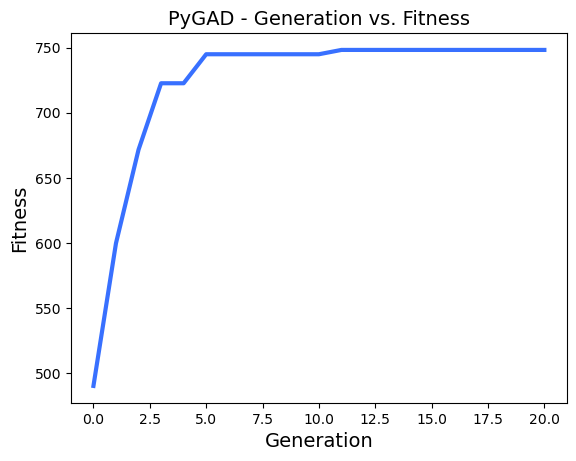

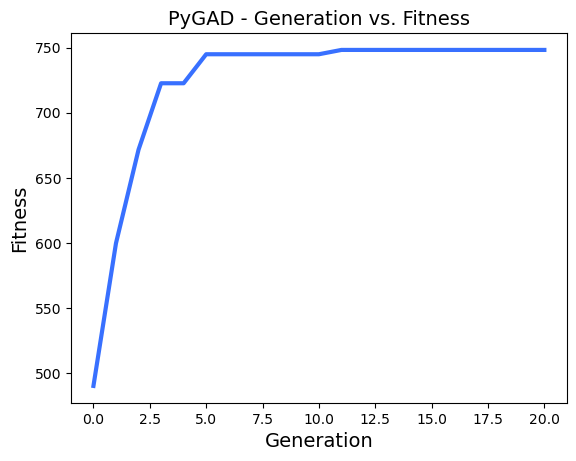

In [69]:
ga_instance.plot_fitness()

# For loop for Genetic Algorithms

In [23]:
best_solutions = []

for out_indexing in range(corrupted_data.shape[1]+1):
    
    def fitness_func_avg(ga_instance, solution, solution_idx):

        inliers = corrupted_data[10:13,:]

        avg_ins = np.mean(inliers, axis=0)
        avg_ins = avg_ins.reshape([1,30])

        particle = corrupted_data[700+out_indexing,:]
        particle = particle.reshape([1,30])

    #     abn_subspace = solution * val_features[6728,:]

    #     abn_subspace = abn_subspace.reshape([1,30])

        avg_in_rec = []

        for index in range(inliers.shape[0]):

            candidate_inlier = inliers[index,:]
            candidate_inlier = candidate_inlier.reshape([1,30])

            in_remain = candidate_inlier * solution

            in_normal_subspace = 1 - solution

            in_replace = in_normal_subspace * avg_ins

            in_candidate = in_remain + in_replace

            z_mean, z_log_var, z = vae.encoder(in_candidate)
            in_candidate_rec = vae.decoder(z)


            rec_loss = tf.keras.losses.MeanSquaredError()(in_candidate,in_candidate_rec)

            avg_in_rec.append(rec_loss.numpy())

        avg_in_rec = np.array(avg_in_rec)
        avg_in_rec = np.mean(avg_in_rec)





    #     z_mean, z_log_var, z = vae.encoder(particle)
    #     reconstruction_1 = vae.decoder(z)

        out_remain = particle * solution

        out_normal_subspace = 1 - solution

        out_replace = avg_ins * out_normal_subspace

        out_candidate = out_remain + out_replace


        z_mean, z_log_var, z = vae.encoder(out_candidate)
        out_candidate_rec = vae.decoder(z)

        rec_loss = tf.keras.losses.MeanSquaredError()(out_candidate,out_candidate_rec)
        rec_loss = rec_loss.numpy()

        fitness = rec_loss / avg_in_rec

        return fitness

    def on_generation(ga):
        print("Generation", ga.generations_completed)

        solution, solution_fitness, solution_idx = ga_instance.best_solution()

        print(solution_fitness)


    fitness_function = fitness_func_avg

    num_generations = 20
    num_parents_mating = 4

    sol_per_pop = 100
    num_genes = corrupted_data.shape[1]

    init_range_low = -2
    init_range_high = 5

    parent_selection_type = "sss"
    keep_parents = 1

    space = [[0,1] for i in range(num_genes)]

    crossover_type = "single_point"

    mutation_type = "random"
    mutation_percent_genes = 10

    ga_instance = pygad.GA(num_generations=num_generations,
                           num_parents_mating=num_parents_mating,
                           fitness_func=fitness_function,
                           sol_per_pop=sol_per_pop,
                           num_genes=num_genes,
                           init_range_low=init_range_low,
                           init_range_high=init_range_high,
                           parent_selection_type=parent_selection_type,
                           keep_parents=keep_parents,
                           crossover_type=crossover_type,
                           mutation_type=mutation_type,
                           mutation_percent_genes=mutation_percent_genes,
                           on_generation=on_generation,
                           gene_space = space)

    ga_instance.run()

    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    print("##########  End of the ", out_indexing, " epoch ##########")
    print("Parameters of the best solution : {solution}".format(solution=solution))

    best_solutions.append(solution)
    
best_solutions = np.array(best_solutions)
np.save('best_solutions.npy', best_solutions)

Generation 1
1.2400088
Generation 2
1.3209153
Generation 3
1.4017613
Generation 4
1.422174
Generation 5
1.422174
Generation 6
1.4366474
Generation 7
1.4739155
Generation 8
1.4723153
Generation 9
1.4956201
Generation 10
1.4723153
Generation 11
1.4723153
Generation 12
1.4794503
Generation 13
1.4917396
Generation 14
1.4917396
Generation 15
1.4917396
Generation 16
1.4917396
Generation 17
1.4917396
Generation 18
1.4917396
Generation 19
1.4917396
Generation 20
1.4917396
##########  End of the  0  epoch ##########
Parameters of the best solution : [1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1.
 1. 0. 0. 0. 0. 0.]
Generation 1
255.26424
Generation 2
270.75244
Generation 3
280.54245
Generation 4
293.25778
Generation 5
295.85608
Generation 6
313.50394
Generation 7
313.50394
Generation 8
313.50394
Generation 9
313.50394
Generation 10
313.50394
Generation 11
313.50394
Generation 12
313.50394
Generation 13
313.50394
Generation 14
313.50394
Generation 15
313.50394
Generatio

Generation 1
2068.806
Generation 2
2364.6914
Generation 3
2329.118
Generation 4
2477.9563
Generation 5
2462.7773
Generation 6
2524.695
Generation 7
2485.5867
Generation 8
2485.5867
Generation 9
2519.063
Generation 10
2594.18
Generation 11
2547.7869
Generation 12
2547.7869
Generation 13
2552.059
Generation 14
2552.059
Generation 15
2552.059
Generation 16
2656.4365
Generation 17
2656.4365
Generation 18
2656.4365
Generation 19
2656.4365
Generation 20
2665.4114
##########  End of the  13  epoch ##########
Parameters of the best solution : [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 0. 0. 1. 0.]
Generation 1
2272.862
Generation 2
2539.8518
Generation 3
2507.984
Generation 4
2507.984
Generation 5
2669.756
Generation 6
2637.6455
Generation 7
2625.0188
Generation 8
2625.0188
Generation 9
2629.3547
Generation 10
2625.0188
Generation 11
2625.0188
Generation 12
2625.0188
Generation 13
2625.0188
Generation 14
2642.7947
Generation 15
2642.7947
Generation 16
2642.

Generation 1
3471.1084
Generation 2
3608.8413
Generation 3
3921.6355
Generation 4
3817.4514
Generation 5
3842.2993
Generation 6
3842.2993
Generation 7
3957.1104
Generation 8
3906.368
Generation 9
3906.368
Generation 10
3906.368
Generation 11
3931.411
Generation 12
3931.411
Generation 13
3931.411
Generation 14
3931.411
Generation 15
3931.411
Generation 16
3931.411
Generation 17
3931.411
Generation 18
3931.411
Generation 19
3931.411
Generation 20
3931.411
##########  End of the  26  epoch ##########
Parameters of the best solution : [1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1.
 1. 0. 1. 0. 0. 0.]
Generation 1
3925.8225
Generation 2
3877.9307
Generation 3
3919.1484
Generation 4
3944.6335
Generation 5
3944.6335
Generation 6
3944.6335
Generation 7
4005.754
Generation 8
4005.754
Generation 9
4071.6772
Generation 10
4071.6772
Generation 11
4071.6772
Generation 12
4071.6772
Generation 13
4071.6772
Generation 14
4071.6772
Generation 15
4071.6772
Generation 16
4071.67

# Measurements

F1 calculator

In [79]:
TP = 3
FP = 1
TN = 22
FN = 4

precision = TP / (TP + FP)

recall = TP / (TP + FN)

F1 = 2 * (precision * recall)/(precision + recall)

MCC = (TP * TN - FP * FN) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))

print("Precision = ", precision)
print("recall = ", recall)
print("F1 = ", F1)
print("MCC = ", MCC)

Precision =  0.75
recall =  0.42857142857142855
F1 =  0.5454545454545454
MCC =  0.47913961749476935


In [48]:
for index in range(corrupted_data.shape[1]):
    print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
    print(best_solutions[index,:])
    print(corrupted_data[700+index,:])
    print("######################################3")

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
[1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1.
 1. 0. 0. 0. 0. 0.]
[0.10054859 0.59685165 0.23774698 0.24732894 0.6486882  0.9409829
 0.69265652 0.42540669 0.36921061 0.70984467 0.78454086 0.89437353
 0.24971938 0.67762474 0.64360346 0.15024313 0.41548516 0.28738241
 0.28956636 0.94035187 0.53923953 0.66112097 0.28444875 0.05866805
 0.46134564 0.68125379 0.25733067 0.18333425 0.69313469 0.24010659]
######################################3
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 1. 0.]
[20.          0.75762593  0.86866608  0.7162405   0.36125389  0.29366277
  0.90369206  0.14690194  0.04087951  0.61418229  0.19055894  0.25650025
  0.46644617  0.56207388  0.66471959  0.4999194   0.36030109  0.34818894
  0.99563774  0.91184597  0.57961046  0.04904301  0.77580245  0.93319094
  0.19946647  0.56109009  0.4533536   0.5588837   0.06989497  0.3189912 ]
#############

In [47]:
corrupted_data[701,:]

array([20.        ,  0.75762593,  0.86866608,  0.7162405 ,  0.36125389,
        0.29366277,  0.90369206,  0.14690194,  0.04087951,  0.61418229,
        0.19055894,  0.25650025,  0.46644617,  0.56207388,  0.66471959,
        0.4999194 ,  0.36030109,  0.34818894,  0.99563774,  0.91184597,
        0.57961046,  0.04904301,  0.77580245,  0.93319094,  0.19946647,
        0.56109009,  0.4533536 ,  0.5588837 ,  0.06989497,  0.3189912 ])

In [80]:
precs = []
recalls = []
F1s = []
mccs = []


for sample_no in range(1,corrupted_data.shape[1]):
    
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    
    sample = corrupted_data[700+sample_no,:]
    sol = best_solutions[sample_no,:]
    
    for gene_no in range(30):
        
        if ((sample[gene_no] == 20) and (sol[gene_no] == 1)):
            
            TP = TP + 1
        
        elif (sample[gene_no] != 20) and (sol[gene_no] == 1):
            
            FP = FP + 1
            
        elif (sample[gene_no] != 20) and (sol[gene_no] == 0):
            
            TN = TN + 1
            
        elif (sample[gene_no] == 20) and (sol[gene_no] == 0):
            
            FN = FN + 1
    
    

    precision = TP / (TP + FP)

    recall = TP / (TP + FN)

    F1 = 2 * (precision * recall)/(precision + recall)
    
    MCC = (TP * TN - FP * FN) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))

    print("###################################################3")
    print(sol)
    print(sample)
    print("Numbers = ", TP, FP, TN, FN)
    print("Precision = ", precision)
    print("recall = ", recall)
    print("F1 = ", F1)
    print("MCC = ", MCC)
    
    precs.append(precision)
    recalls.append(recall)
    F1s.append(F1)
    mccs.append(MCC)


precs = np.array(precs)
recalls = np.array(recalls)
F1s = np.array(F1s)
mccs = np.array(mccs)

###################################################3
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 1. 0.]
[20.          0.75762593  0.86866608  0.7162405   0.36125389  0.29366277
  0.90369206  0.14690194  0.04087951  0.61418229  0.19055894  0.25650025
  0.46644617  0.56207388  0.66471959  0.4999194   0.36030109  0.34818894
  0.99563774  0.91184597  0.57961046  0.04904301  0.77580245  0.93319094
  0.19946647  0.56109009  0.4533536   0.5588837   0.06989497  0.3189912 ]
Numbers =  1 3 26 0
Precision =  0.25
recall =  1.0
F1 =  0.4
MCC =  0.4734320764739993
###################################################3
[1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0.]
[20.         20.          0.058271    0.17217135  0.43073989  0.06525565
  0.3502004   0.55423195  0.70373776  0.20355026  0.17072301  0.87909193
  0.43761228  0.42995476  0.37078403  0.47957613  0.12407486  0.23815116
  0.03675877  0.38736082  0.9457483

In [59]:
import matplotlib.pyplot as plt

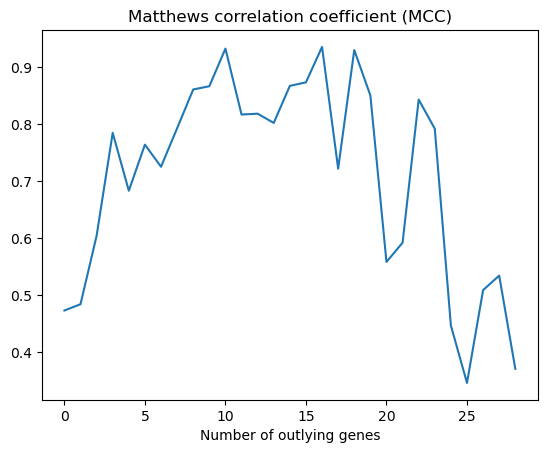

In [71]:
# precs = np.array(precs)
# recalls = np.array(recalls)
# F1s = np.array(F1s)
# mccs = np.array(mccs)

plt.title("Matthews correlation coefficient (MCC)")
plt.plot(mccs)
plt.xlabel("Number of outlying genes")
plt.savefig("MCC.png")

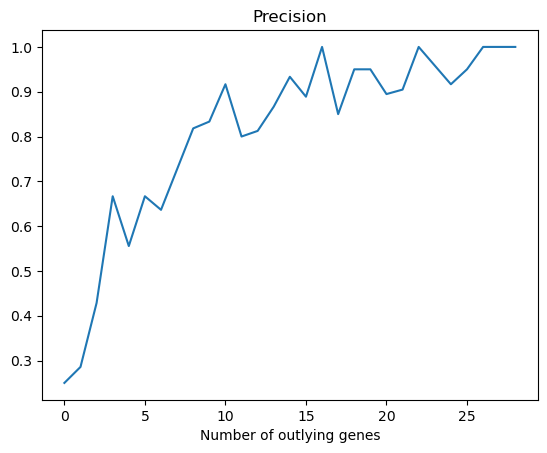

In [72]:
plt.title("Precision")
plt.plot(precs)
plt.xlabel("Number of outlying genes")
plt.savefig("Precision.png")

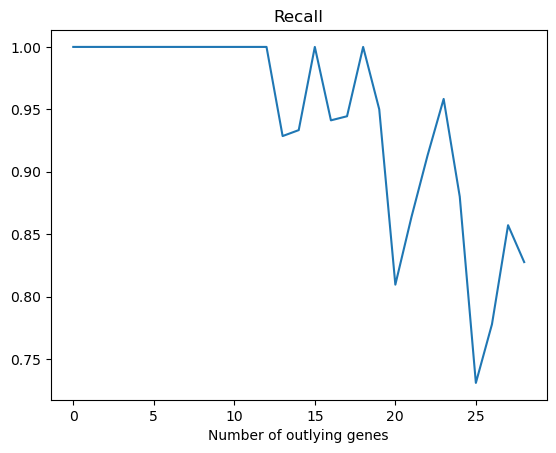

In [81]:
plt.title("Recall")
plt.plot(recalls)
plt.xlabel("Number of outlying genes")
plt.savefig("Recall.png")

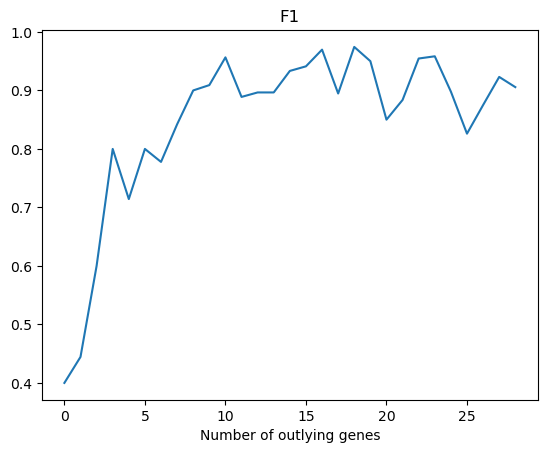

In [82]:
plt.title("F1")
plt.plot(F1s)
plt.xlabel("Number of outlying genes")
plt.savefig("F1.png")